## Part 1 — Planar Tracking and Template Warp

This notebook is a **clean, reader-friendly** walkthrough of **Part 1**.

It is aligned with the real project code:
- Parameters + paths: `config.py` → `Part1Config`
- Tracking + homography: `tracker.py` → `PlanarTracker`
- Overlay: `tracker.py` → `warp_and_overlay`

### Goal
Given:
- a reference planar image (the target)
- a template image (what we want to paste)
- an input video

We estimate a homography per frame and warp the template into the video.

---

### Setup
Run from inside the `augmented-reality-planar/` folder so relative `data/...` paths resolve.


In [6]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from config import Part1Config
from tracker import PlanarTracker, warp_and_overlay

ROOT = Path().resolve()
cfg = Part1Config()

ref_path = ROOT / cfg.reference_path
template_path = ROOT / cfg.template_path
video_path = ROOT / cfg.video_path

print("reference:", ref_path)
print("template:", template_path)
print("video:", video_path)


reference: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\reference.JPG
template: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\template.JPG
video: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\video_part1.mp4


### Step 1 — Load inputs (reference + template + one video frame)

We start with **a single frame** to keep things fast and easy to understand.


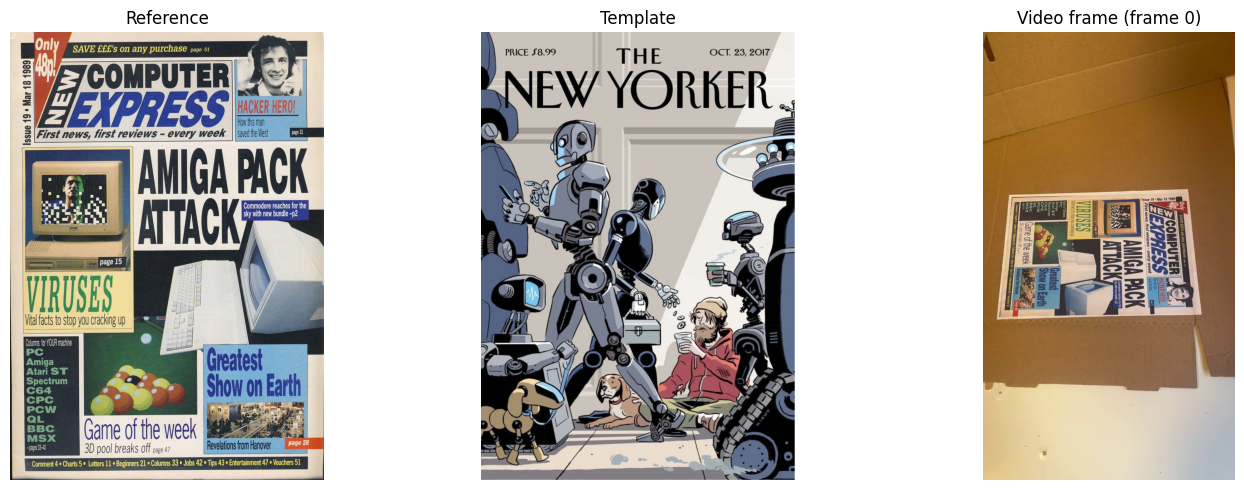

In [7]:
ref_bgr = cv2.imread(str(ref_path))
template_bgr = cv2.imread(str(template_path))

assert ref_bgr is not None, f"Could not read reference: {ref_path}"
assert template_bgr is not None, f"Could not read template: {template_path}"

if cfg.resize_template_to_reference:
    h, w = ref_bgr.shape[:2]
    template_bgr = cv2.resize(template_bgr, (w, h), interpolation=cv2.INTER_AREA)

cap = cv2.VideoCapture(str(video_path))
assert cap.isOpened(), f"Could not open video: {video_path}"

ok, frame_bgr = cap.read()
cap.release()
assert ok and frame_bgr is not None, "Could not read the first frame"

# Show inputs
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB))
ax[0].set_title("Reference")
ax[1].imshow(cv2.cvtColor(template_bgr, cv2.COLOR_BGR2RGB))
ax[1].set_title("Template")
ax[2].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
ax[2].set_title("Video frame (frame 0)")
for a in ax:
    a.axis("off")
plt.tight_layout()


### Step 2 — Track the plane (SIFT → matches → RANSAC homography)

We use the project’s tracker as-is (`PlanarTracker`).


In [8]:
tracker = PlanarTracker(ref_bgr, cfg)

H, corners, dbg = tracker.track(frame_bgr)
print("debug:", dbg)
print("H is None?", H is None)
print("corners:", None if corners is None else corners.reshape(-1, 2))


debug: {'good': 1734, 'inliers': 1350, 'held': 0, 'smoothed': 0}
H is None? False
corners: [[ 868.44336   689.72156 ]
 [ 917.45984  1208.4032  ]
 [  71.347404 1221.1318  ]
 [ 125.207466  707.74164 ]]


### Step 2b — Visualize features and matching (important)

This section shows what the tracker is doing internally:
- SIFT keypoints on the reference and the video frame
- matches after Lowe’s ratio test
- (optional) inlier matches after homography RANSAC


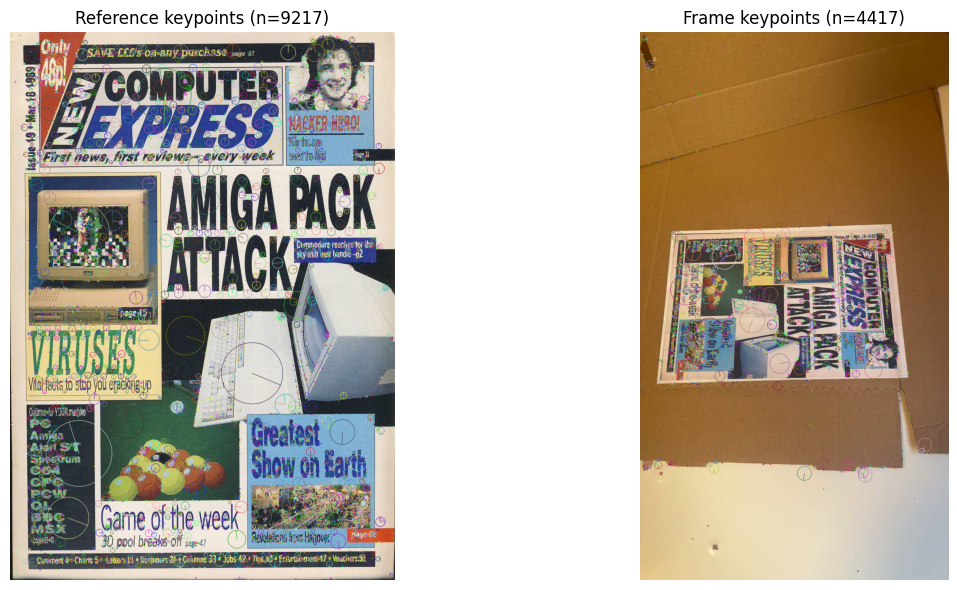

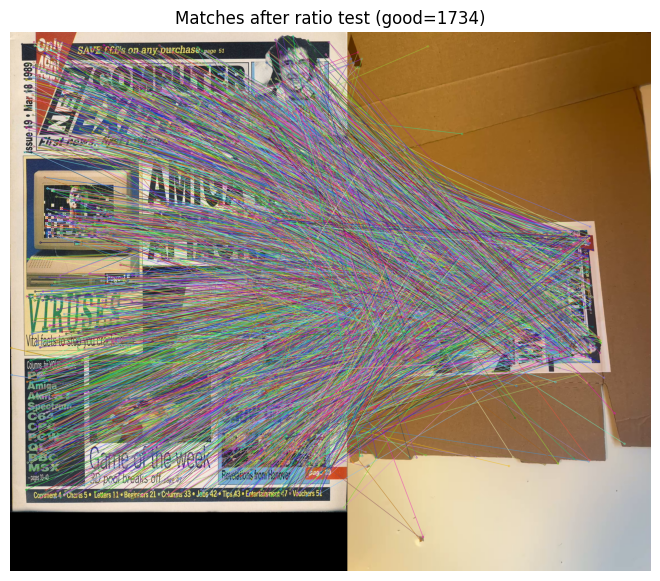

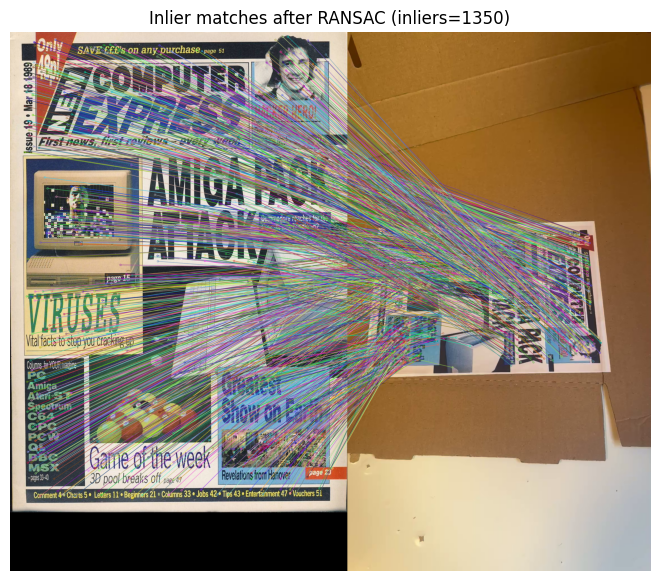

In [9]:
# Use the tracker debug API (from tracker.py) to visualize matches/inliers
H_dbg, corners_dbg, dbg2, extra = tracker.track_debug(frame_bgr)

kp_fr = extra.get("kp_frame")
good_pairs = extra.get("good_pairs", [])
good_matches = extra.get("good_matches", [])
inlier_mask = extra.get("inlier_mask")

# 1) Keypoints
ref_kp_vis = cv2.drawKeypoints(
    ref_bgr,
    tracker.kp_ref,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
fr_kp_vis = cv2.drawKeypoints(
    frame_bgr,
    kp_fr if kp_fr is not None else [],
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(cv2.cvtColor(ref_kp_vis, cv2.COLOR_BGR2RGB))
ax[0].set_title(f"Reference keypoints (n={len(tracker.kp_ref)})")
ax[1].imshow(cv2.cvtColor(fr_kp_vis, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"Frame keypoints (n={0 if kp_fr is None else len(kp_fr)})")
for a in ax:
    a.axis("off")
plt.tight_layout()

# 2) Matches after ratio test
match_vis = cv2.drawMatchesKnn(
    ref_bgr,
    tracker.kp_ref,
    frame_bgr,
    kp_fr,
    good_pairs,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.figure(figsize=(16, 7))
plt.imshow(cv2.cvtColor(match_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Matches after ratio test (good={len(good_matches)})")
plt.axis("off")
plt.show()

# 3) Inlier matches (after homography RANSAC), if available
if inlier_mask is not None and len(good_matches) == int(inlier_mask.shape[0]):
    inl = inlier_mask.ravel().astype(bool)
    inlier_matches = [m for m, keep in zip(good_matches, inl) if keep]

    inlier_vis = cv2.drawMatches(
        ref_bgr,
        tracker.kp_ref,
        frame_bgr,
        kp_fr,
        inlier_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.figure(figsize=(16, 7))
    plt.imshow(cv2.cvtColor(inlier_vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Inlier matches after RANSAC (inliers={len(inlier_matches)})")
    plt.axis("off")
    plt.show()


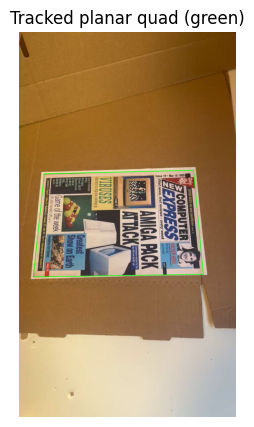

In [10]:
vis = frame_bgr.copy()
if corners is not None:
    quad = corners.reshape(-1, 2).astype(np.int32)
    cv2.polylines(vis, [quad.reshape(-1, 1, 2)], True, (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Tracked planar quad (green)")
plt.axis("off")
plt.show()


### Step 3 — Warp and overlay the template

This uses `warp_and_overlay()` exactly like `main.py` does in Part 1.


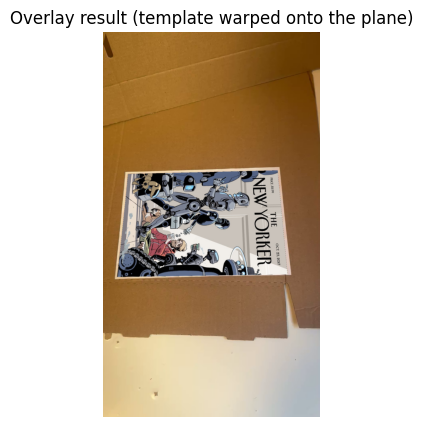

In [11]:
if H is None:
    out_bgr = frame_bgr
else:
    out_bgr = warp_and_overlay(frame_bgr, template_bgr, H)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(out_bgr, cv2.COLOR_BGR2RGB))
plt.title("Overlay result (template warped onto the plane)")
plt.axis("off")
plt.show()
